# RQ2 

## Setup

* Follow the instructions on ```Readme.md```
* Change the ```config.py``` file by uncommenting the RQ2 overrides at the end
* Inside the *pipeline* folder, run ```python -m src.rq2``` 
* Results are saved on ```results/RQ2```

In [13]:
from src.config import *
RQ1_OUT_PATH = f"../results/RQ1/{DATASET_NAME}_llm_clones.json"
OUT_PATH = f"../results/RQ2/{DATASET_NAME}_llm_clones.json"
FINAL_DATASET = f"../results/RQ2/{DATASET_NAME}_clone_dataset.json"
RQ1_REPROMPT_PATH = f"../results/RQ1/{DATASET_NAME}_reprompt.json"
REPROMPT_PATH = f"../results/RQ2/{DATASET_NAME}_reprompt.json"
FAILED_REPROMPT_PATH = f"../results/RQ2/{DATASET_NAME}_failed_reprompt.json"
RQ1_FILTERED_PATH_CODEBLEU = f"../results/RQ1/{DATASET_NAME}_filtered_codebleu.json"
FILTERED_PATH_CODEBLEU = f"../results/RQ2/{DATASET_NAME}_filtered_codebleu.json"
FILTERED_PATH_TESTS = f"../results/RQ2/{DATASET_NAME}_filtered_tests.json"
CLUSTER_DIR = "../results/RQ2/clustering"

MODEL_COLORS = {
    DeepSeek: "#007399",   
    Gpt20b: "#228833",     
    LLama3: "#CC3344",     
    Gemma3: "#CC8800"    
}
PLOT_RESULTS = "../results/RQ2/plots/"

## Results

### Survival numbers

In [14]:
import json
import os

# List of JSON files (adjust paths)
json_files = [
    OUT_PATH,
    FILTERED_PATH_CODEBLEU,
    FILTERED_PATH_TESTS,
    FINAL_DATASET
]

def count_clones_in_json(file_path):
    """Counts total clones in a JSON file."""
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        return 0

    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    total_clones = sum(len(entry.get("clones", [])) for entry in data)
    return total_clones

# Analyze all files
initial_count = None
for i, json_file in enumerate(json_files, 1):
    num_clones = count_clones_in_json(json_file)
    
    if i == 1:
        initial_count = num_clones
        pct = 100.0
    else:
        pct = (num_clones / initial_count) * 100 if initial_count else 0
    
    print(f"Stage {i}: {num_clones} clones ({pct:.1f}% of original)")


Stage 1: 2500 clones (100.0% of original)
Stage 2: 1559 clones (62.4% of original)
Stage 3: 804 clones (32.2% of original)
Stage 4: 134 clones (5.4% of original)


### Codebleu 

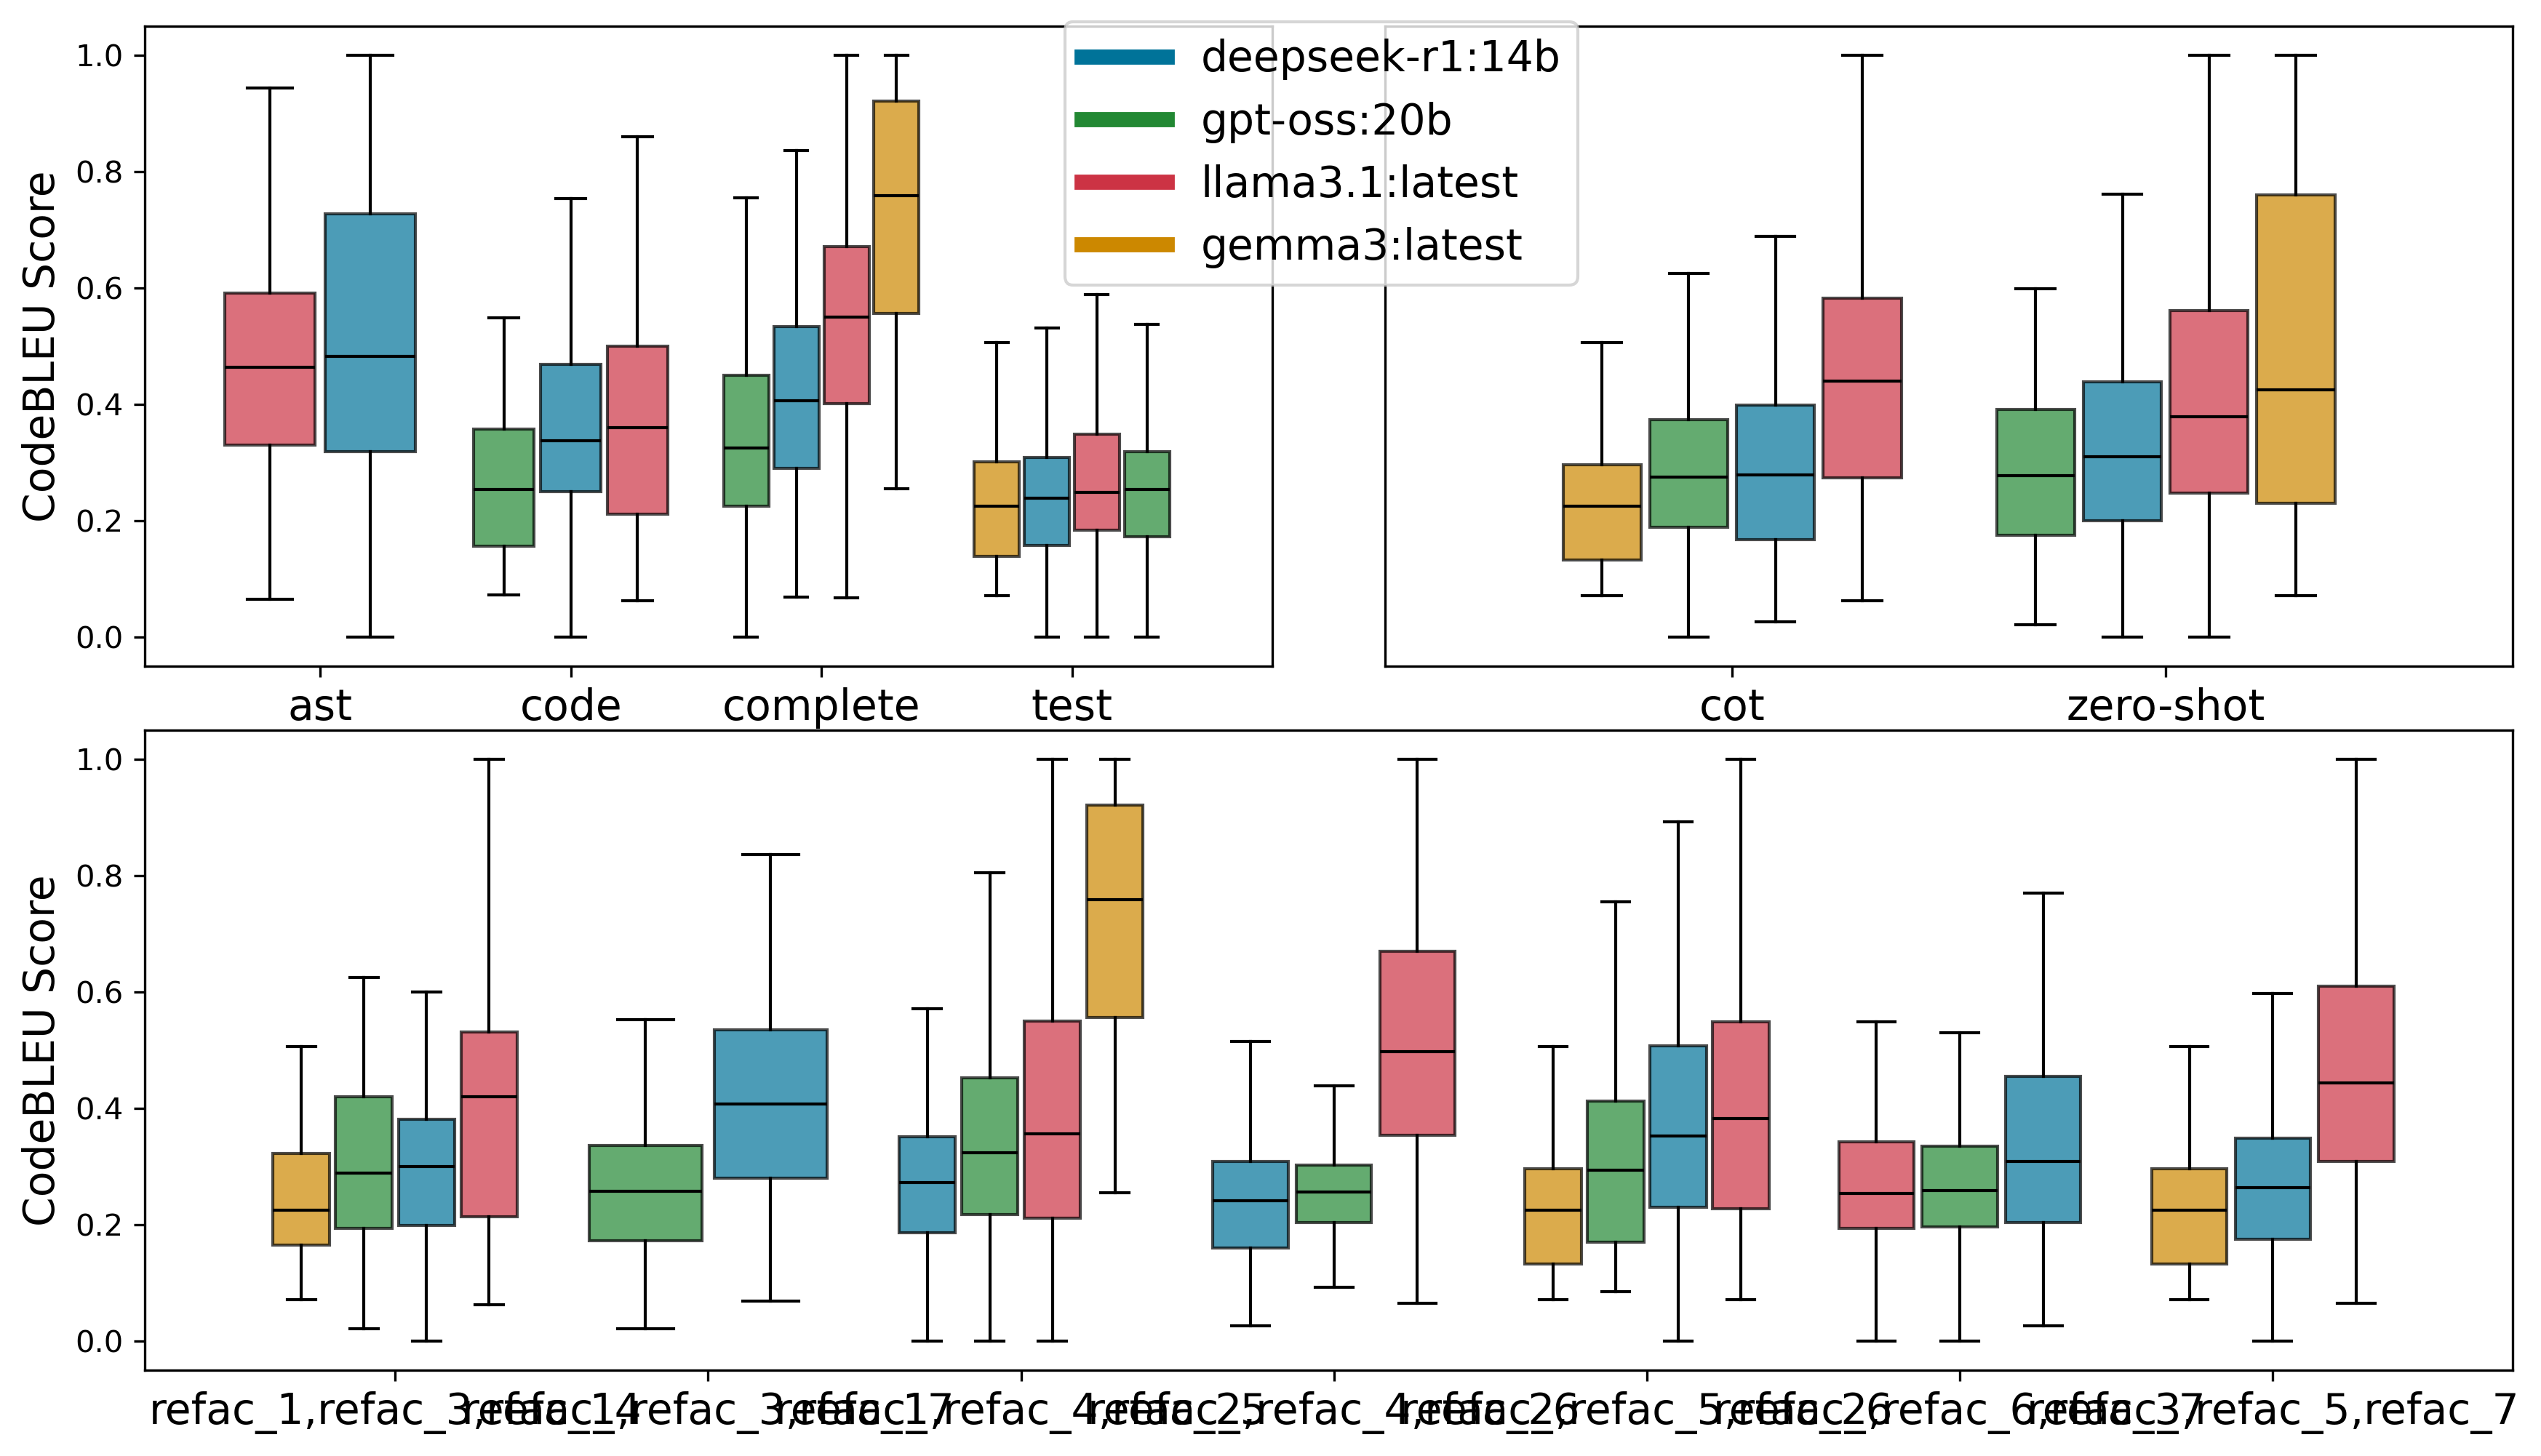

In [15]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

with open(OUT_PATH, "r", encoding="utf-8") as f:
    dataset = json.load(f)

scores_by_model = {}
for entry in dataset:
    for clone in entry.get("clones", []):
        if clone.get("code") == "None":  # skip invalid entries
            continue

        model = clone.get("model", "unknown")
        context = clone.get("context", "unknown")
        strategy = clone.get("strategy", "unknown")
        score_dict = clone.get("metrics", {}).get("codebleu", {})
        score = score_dict.get("originalcode")

        if score is not None:
            model_dict = scores_by_model.setdefault(model, {"context": {}, "strategy": {}, "refacs": {}})
            model_dict["context"].setdefault(context, []).append(score)
            model_dict["strategy"].setdefault(strategy, []).append(score)

            refacs = clone.get("refacs", [])
            if isinstance(refacs, list):
                for ref in refacs:
                    model_dict["refacs"].setdefault(ref, []).append(score)
            elif isinstance(refacs, str):
                model_dict["refacs"].setdefault(refacs, []).append(score)

categories = ["context", "strategy", "refacs"]
fig = plt.figure(figsize=(14, 8), dpi=300)


gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.1, wspace=0.1)
axes = [fig.add_subplot(gs[0, 0]),  # context
        fig.add_subplot(gs[0, 1]),  # strategy
        fig.add_subplot(gs[1, :])]  # refacs spanning both columns

for ax, cat in zip(axes, categories):
    labels = set()
    for grouped in scores_by_model.values():
        labels.update(grouped[cat].keys())
    labels = sorted(labels)
    num_labels = len(labels)

    for i, label in enumerate(labels):
        # Compute median for each model for this label
        model_scores = []
        for model, grouped in scores_by_model.items():
            scores = grouped[cat].get(label, [])
            if scores:
                model_scores.append((model, scores, np.median(scores)))

        # Sort models by median ascending
        model_scores = sorted(model_scores, key=lambda x: x[2])

        for j, (model, scores, _) in enumerate(model_scores):
            pos = i - 0.4 + (j + 0.5) * (0.8 / len(model_scores))
            bp = ax.boxplot(
                scores, positions=[pos], widths=0.8 / len(model_scores) * 0.9,
                patch_artist=True, medianprops=dict(color="black"), showfliers=False
            )
            for patch in bp['boxes']:
                patch.set_facecolor(MODEL_COLORS.get(model, "#333333"))
                patch.set_alpha(0.7)


    ax.set_xticks(np.arange(num_labels))
    ax.set_xticklabels(labels, fontsize=14)
    ax.set_ylabel("CodeBLEU Score", fontsize=14)


axes[1].get_yaxis().set_visible(False)

# Floating legend between first two subplots
legend_ax = fig.add_axes([0.46, 0.757, 0.1, 0.1])  # [left, bottom, width, height] in figure coords
legend_ax.axis('off')
handles = [plt.Line2D([0], [0], color=color, lw=5) for color in MODEL_COLORS.values()]
labels = list(MODEL_COLORS.keys())
legend_ax.legend(handles, labels, loc='center', fontsize=14,  ncol=1)

plt.tight_layout()
pdf_path = os.path.join(PLOT_RESULTS, "RQ2codebleuResults.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show()


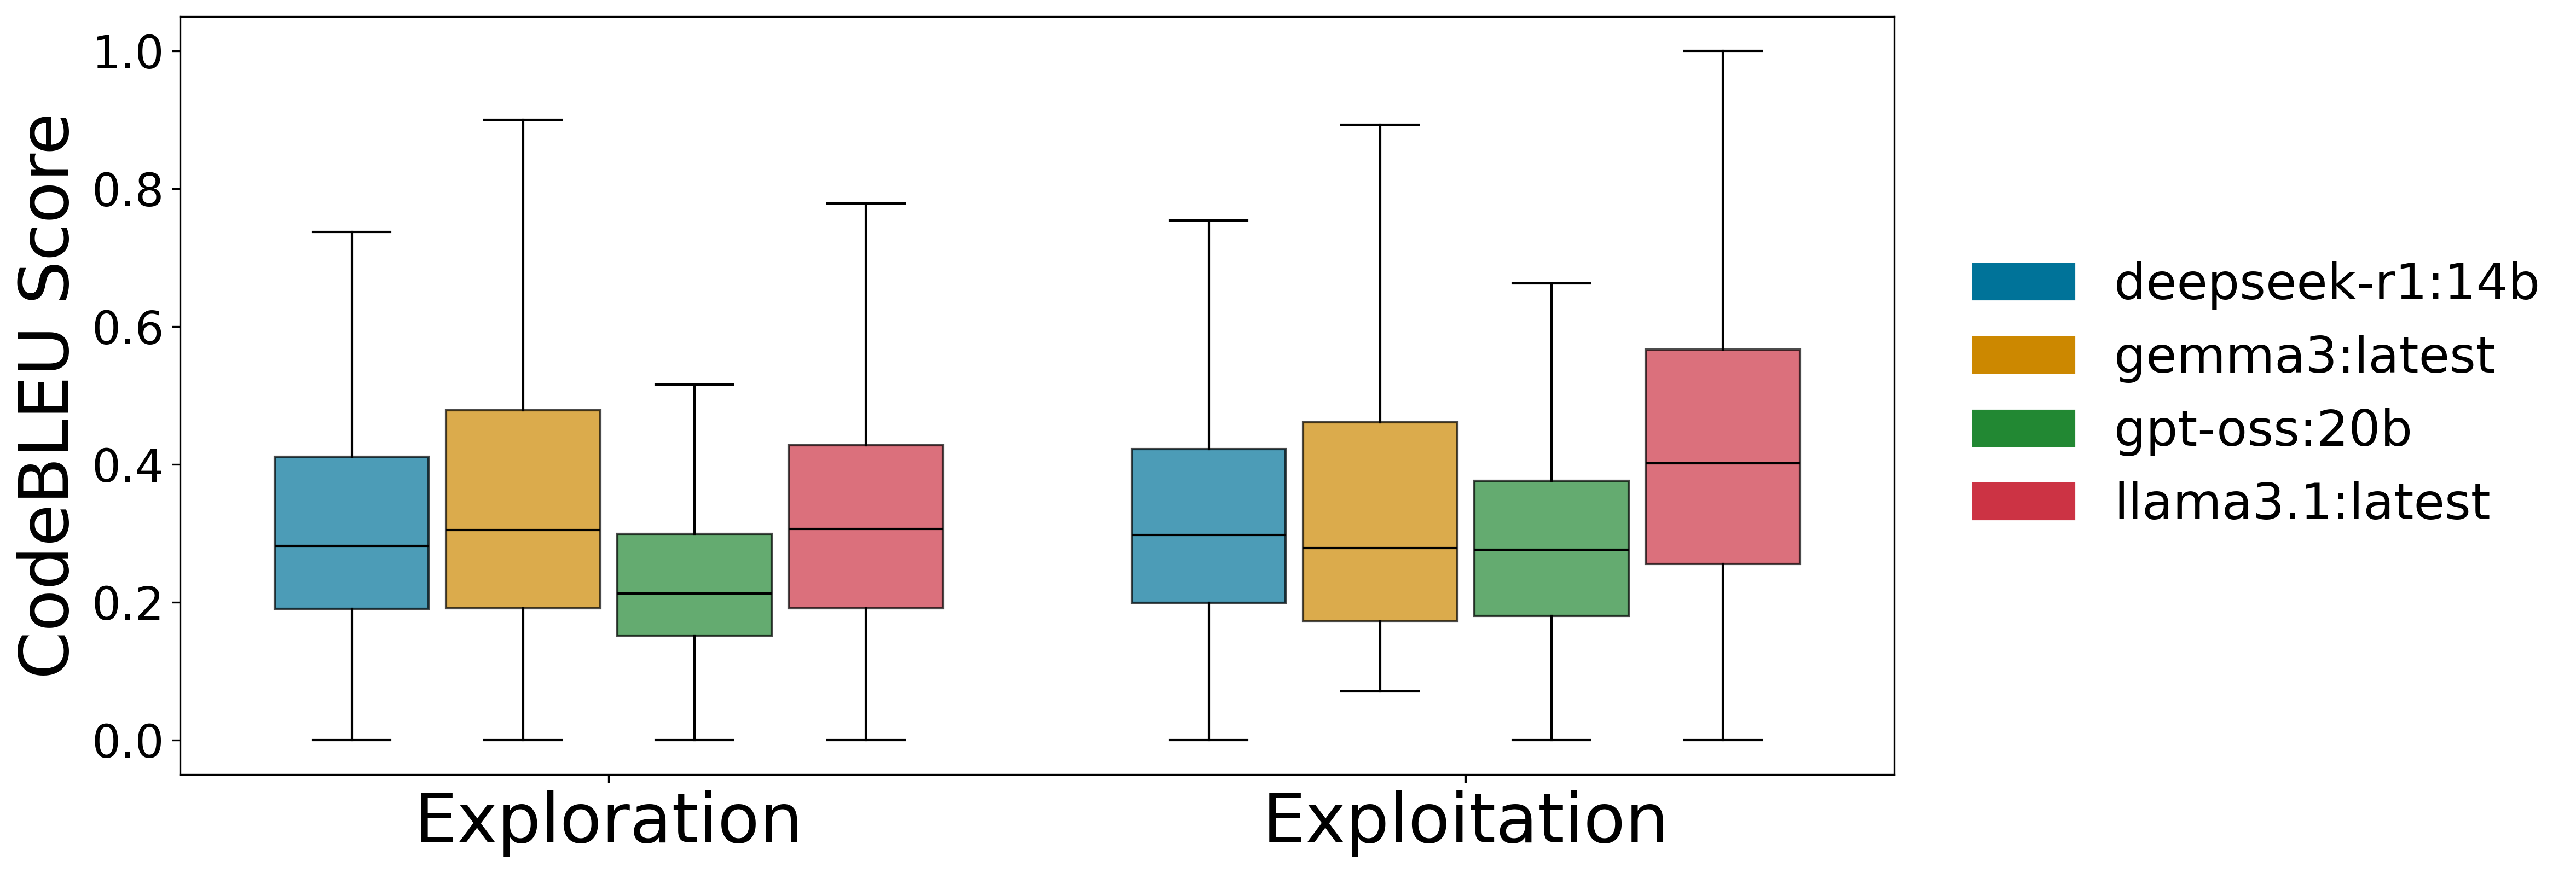

In [29]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.patches as mpatches

def load_scores(path):
    """Load overall CodeBLEU scores per model from a dataset."""
    with open(path, "r", encoding="utf-8") as f:
        dataset = json.load(f)

    scores_by_model = {}
    for entry in dataset:
        for clone in entry.get("clones", []):
            if clone.get("code") == "None":
                continue
            model = clone.get("model", "unknown")
            score_dict = clone.get("metrics", {}).get("codebleu", {})
            score = score_dict.get("originalcode")
            if score is not None:
                scores_by_model.setdefault(model, []).append(score)
    return scores_by_model
 
scores1 = load_scores(RQ1_OUT_PATH)
scores2 = load_scores(OUT_PATH)

datasets = [("Exploration", scores1), ("Exploitation", scores2)]
all_models = sorted(set(scores1.keys()).union(scores2.keys()))

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

num_models = len(all_models)
box_width = 0.8 / num_models   
x_base = np.arange(len(datasets)) 
 
for i, (dataset_name, scores) in enumerate(datasets):
    for j, model in enumerate(all_models):
        model_scores = scores.get(model, [])
        if not model_scores:
            continue
       
        pos = i - 0.4 + (j + 0.5) * box_width
        bp = ax.boxplot(
            model_scores,
            positions=[pos],
            widths=box_width * 0.9,
            patch_artist=True,
            medianprops=dict(color="black"),
            showfliers=False
        )
        
        color = MODEL_COLORS.get(model, "#333333")
        for patch in bp['boxes']:
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

ax.tick_params(axis='y', labelsize=20)
ax.set_xticks(x_base)
ax.set_xticklabels([name for name, _ in datasets], fontsize=30) 
ax.set_ylabel("CodeBLEU Score", fontsize=30)  
plt.tight_layout()
plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.15) 
ax.set_xlim(-0.5, len(datasets) - 0.5)

legend_handles = [
    mpatches.Patch(color=MODEL_COLORS.get(model, "#333333"), label=model)
    for model in all_models
]
ax.legend(
    handles=legend_handles,
    title="",
    fontsize=22,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),   
    frameon=False,                
)
pdf_path = os.path.join(PLOT_RESULTS, "RQ2vsRQ1codebleu.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show() 

### Tests

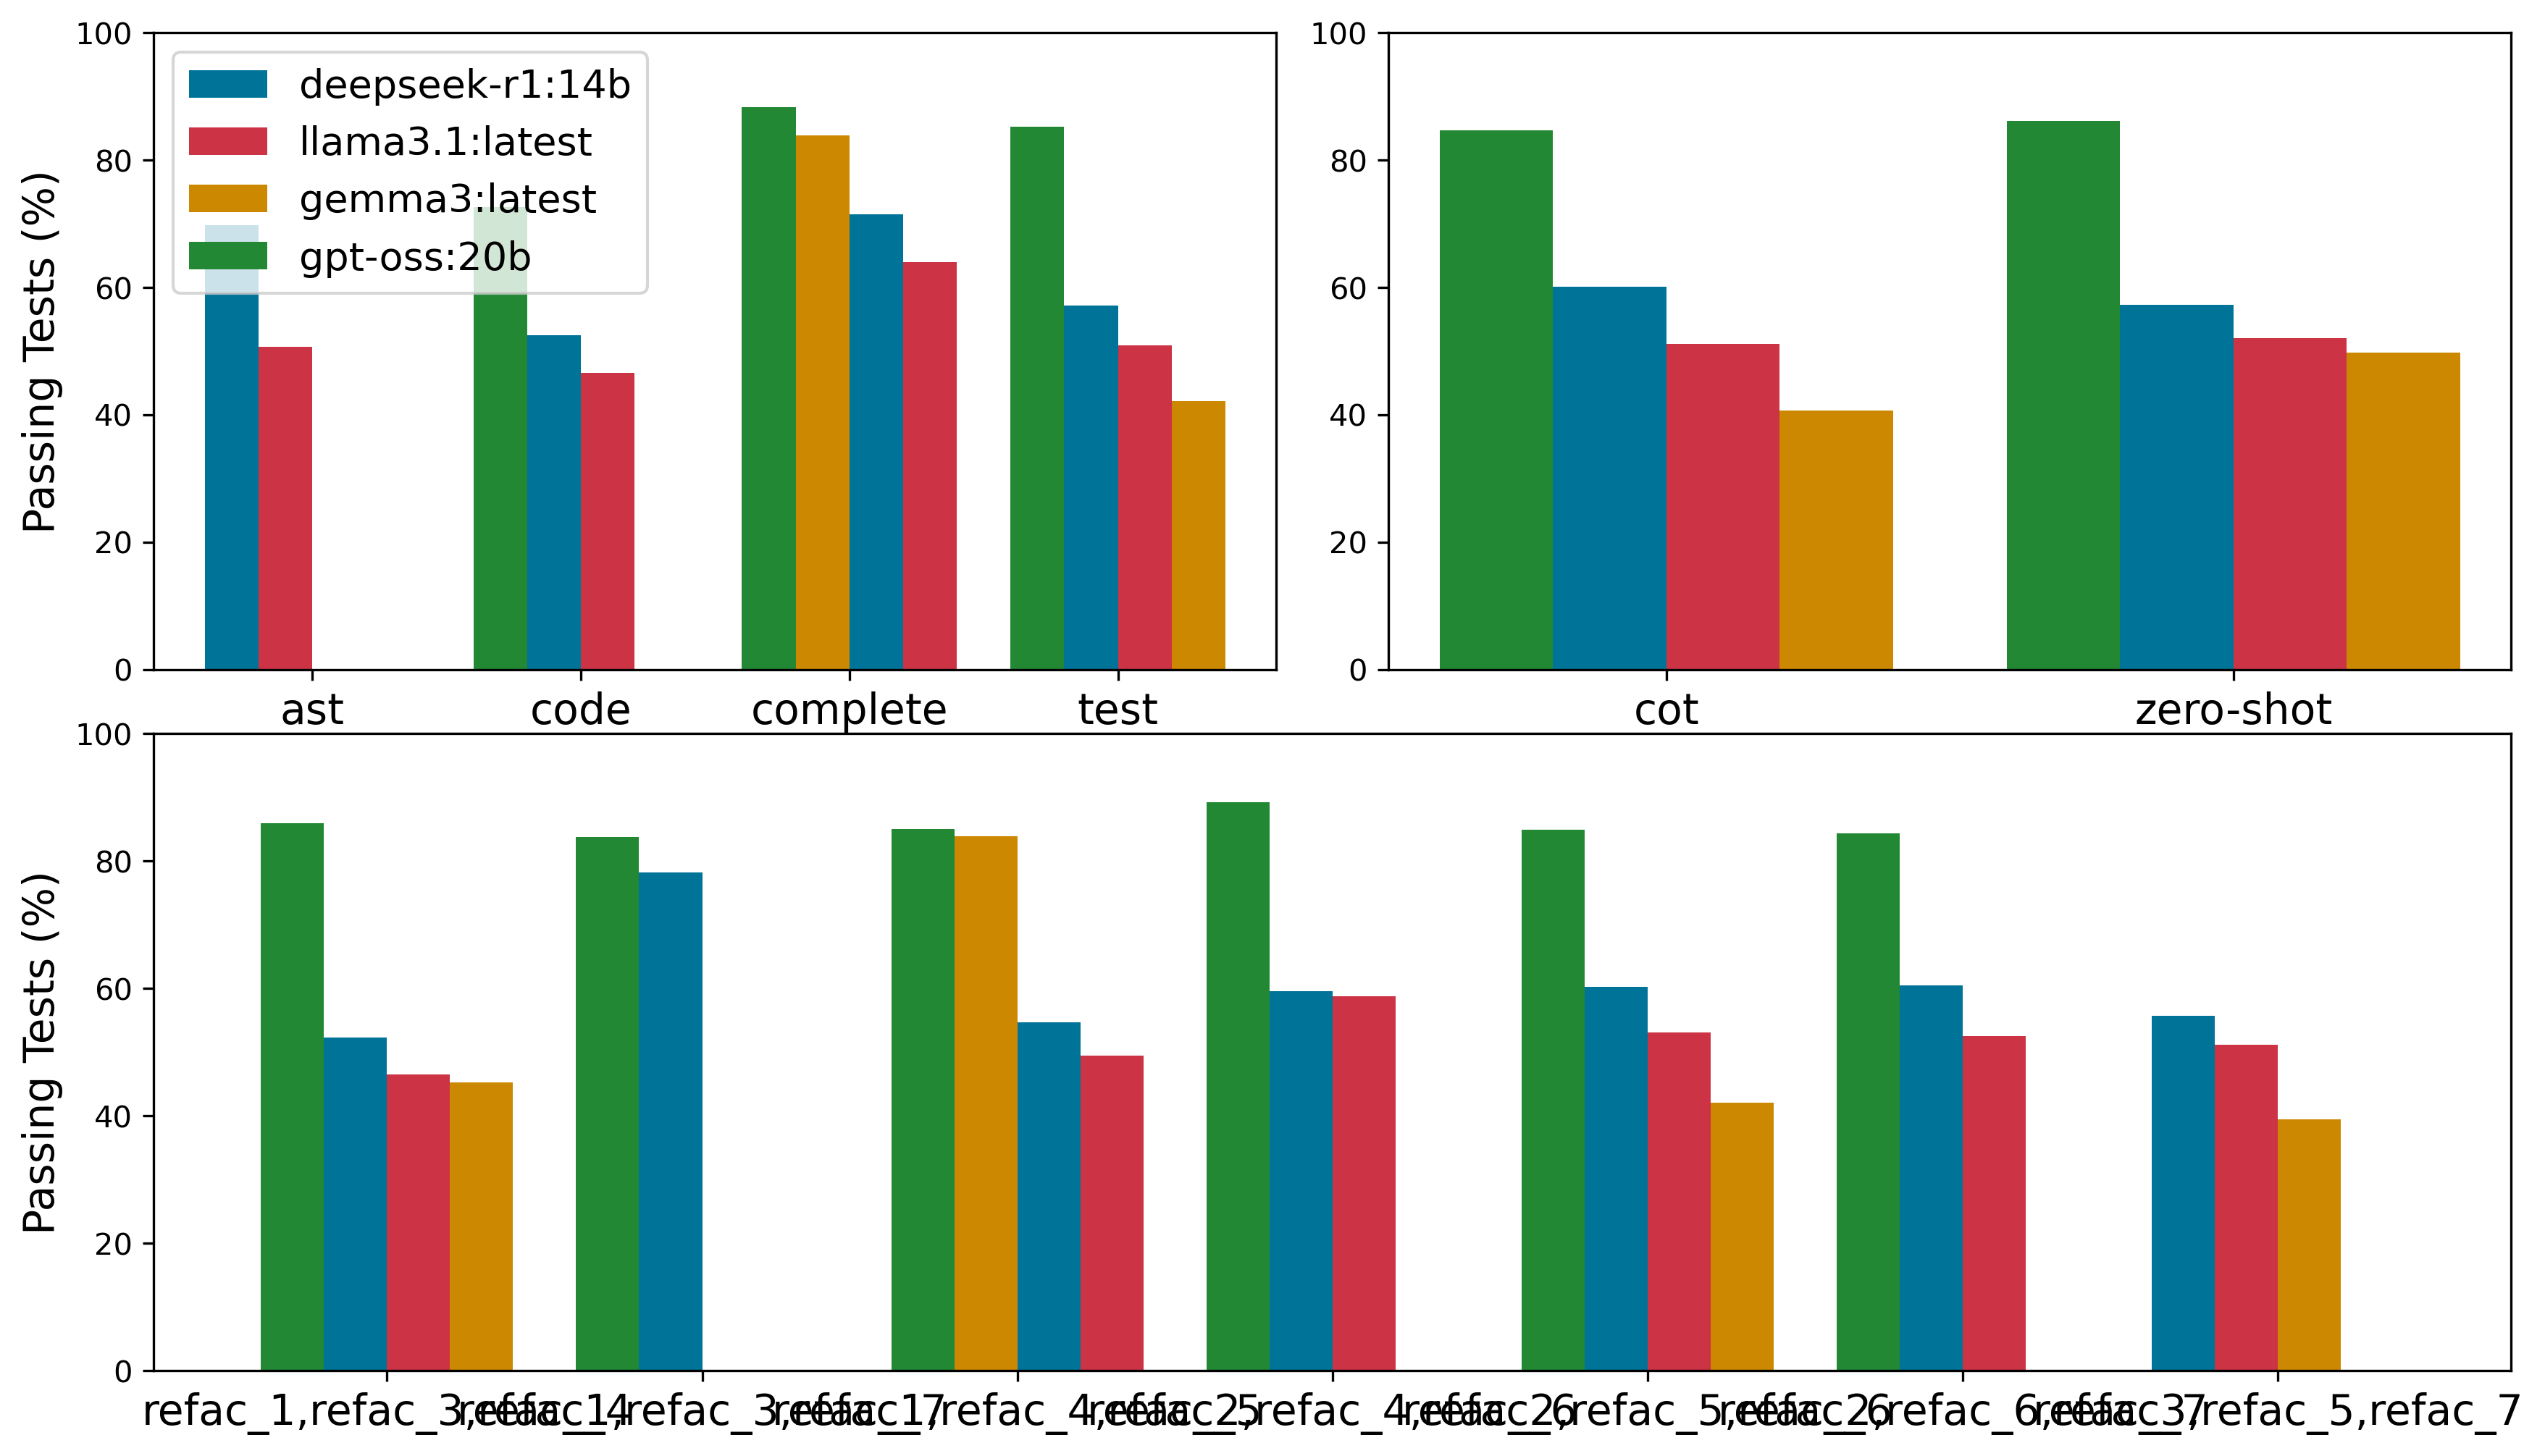

In [17]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os  
with open(FILTERED_PATH_CODEBLEU, "r", encoding="utf-8") as f:
    dataset = json.load(f)
 
models = sorted({clone.get("model", "unknown") for entry in dataset for clone in entry.get("clones", [])})
 
grouped_by_context = {}
grouped_by_strategy = {}
grouped_by_refacs = {}

for entry in dataset:
    if not entry.get("clones"):
        continue
    num_tests = max(len(clone.get("test_results", {})) for clone in entry["clones"])
    
    for clone in entry.get("clones", []):
        model = clone.get("model", "unknown")
        context = clone.get("context", "unknown")
        strategy = clone.get("strategy", "unknown")
        refacs_list = clone.get("refacs", ["unknown"])
        results = clone.get("test_results", {})

        # Fill missing tests as ERROR
        if len(results) < num_tests:
            for i in range(num_tests - len(results)):
                results[f"missing_test_{i+1}"] = "ERROR"

        # Initialize dicts
        grouped_by_context.setdefault(context, {})
        grouped_by_strategy.setdefault(strategy, {})
        for refac in refacs_list:
            grouped_by_refacs.setdefault(refac, {})

        # Count PASS / TOTAL per model
        def update_group(group, key):
            group[key].setdefault(model, {"PASS": 0, "TOTAL": 0})
            for status in results.values():
                group[key][model]["TOTAL"] += 1
                if status.upper() == "PASS":
                    group[key][model]["PASS"] += 1

        update_group(grouped_by_context, context)
        update_group(grouped_by_strategy, strategy)
        for refac in refacs_list:
            update_group(grouped_by_refacs, refac)

def prepare_percent_data(grouped_dict):
    labels = sorted(grouped_dict.keys())
    percentages = {model: [] for model in models}
    for label in labels:
        for model in models:
            data = grouped_dict[label].get(model, {"PASS": 0, "TOTAL": 0})
            pct = data["PASS"]/data["TOTAL"]*100 if data["TOTAL"] > 0 else 0
            percentages[model].append(pct)
    return labels, percentages

filters_context, pct_context = prepare_percent_data(grouped_by_context)
filters_strategy, pct_strategy = prepare_percent_data(grouped_by_strategy)
filters_refacs, pct_refacs = prepare_percent_data(grouped_by_refacs)

fig = plt.figure(figsize=(14, 8), dpi=300)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.1, wspace=0.1)
axes = [fig.add_subplot(gs[0, 0]),  # context
        fig.add_subplot(gs[0, 1]),  # strategy
        fig.add_subplot(gs[1, :])]  # refacs

def plot_grouped_bar(ax, labels, percentages_dict, title, show_ylabel=True):
    x = np.arange(len(labels))
    total_models = len(models)
    width = 0.8 / total_models

    for i, label in enumerate(labels): 
        model_pcts = [(model, percentages_dict[model][i]) for model in models] 
        model_pcts_sorted = sorted(model_pcts, key=lambda x: x[1], reverse=True) 
        for j, (model, pct) in enumerate(model_pcts_sorted):
            ax.bar(
                i - 0.4 + (j + 0.5) * width, 
                pct, 
                width=width, 
                color=MODEL_COLORS.get(model, "#333333"),
                label=model if i == 0 else ""  
            )

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=14)
    if show_ylabel:
        ax.set_ylabel("Passing Tests (%)", fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_title(title)
     
plot_grouped_bar(axes[0], filters_context, pct_context, "")
plot_grouped_bar(axes[1], filters_strategy, pct_strategy, "", show_ylabel=False)
plot_grouped_bar(axes[2], filters_refacs, pct_refacs, "")
 
handles, labels_legend = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels_legend, title="", loc='upper left', fontsize=13)
plt.tight_layout()

pdf_path = os.path.join(PLOT_RESULTS, "RQ2testResults.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show()


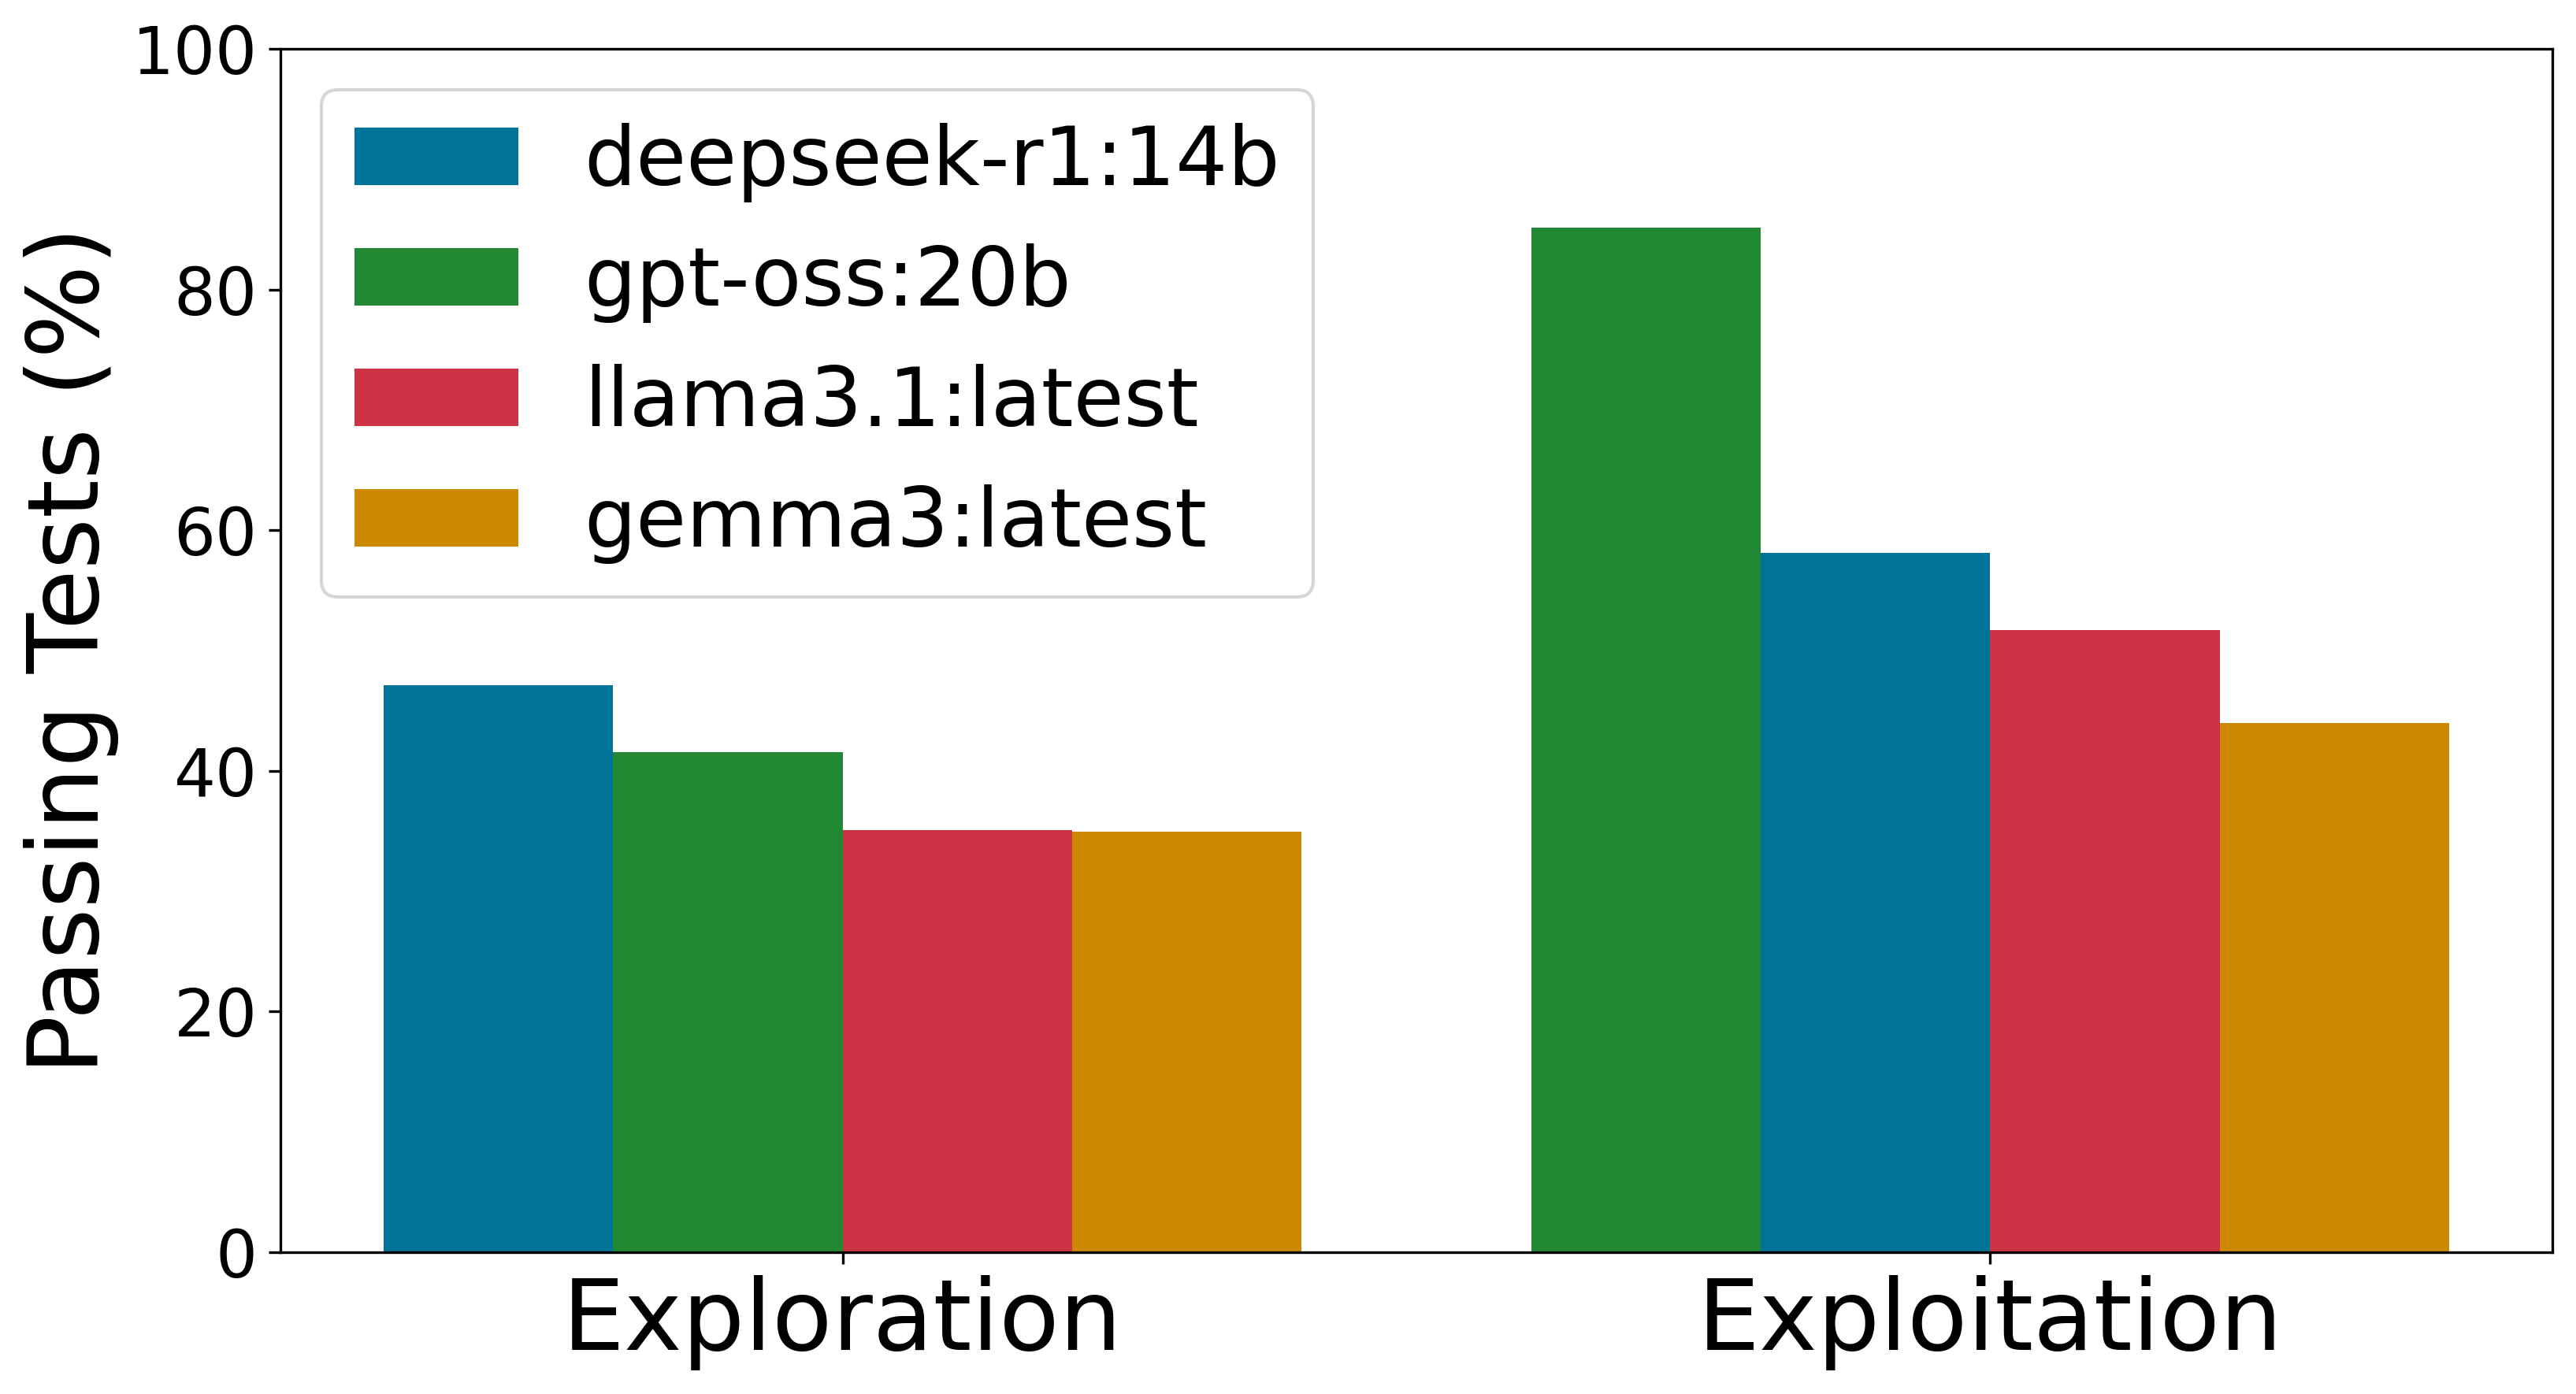

In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_pass_percent(path):
    """Compute overall passing percentage per model for a dataset."""
    with open(path, "r", encoding="utf-8") as f:
        dataset = json.load(f)

    # Identify all models
    models = sorted({clone.get("model", "unknown") for entry in dataset for clone in entry.get("clones", [])})

    pass_counts = {model: {"PASS": 0, "TOTAL": 0} for model in models}

    for entry in dataset:
        if not entry.get("clones"):
            continue
        num_tests = max(len(clone.get("test_results", {})) for clone in entry["clones"])
        for clone in entry.get("clones", []):
            model = clone.get("model", "unknown")
            results = clone.get("test_results", {})

            # Fill missing tests as ERROR
            if len(results) < num_tests:
                for i in range(num_tests - len(results)):
                    results[f"missing_test_{i+1}"] = "ERROR"

            for status in results.values():
                pass_counts[model]["TOTAL"] += 1
                if status.upper() == "PASS":
                    pass_counts[model]["PASS"] += 1

    percentages = {model: (pass_counts[model]["PASS"] / pass_counts[model]["TOTAL"] * 100
                           if pass_counts[model]["TOTAL"] > 0 else 0) for model in models}

    return models, percentages

 
models, pct1 = load_pass_percent(RQ1_FILTERED_PATH_CODEBLEU)
_, pct2 = load_pass_percent(FILTERED_PATH_CODEBLEU)

datasets = ["Exploration", "Exploitation"]
dataset_percentages = [pct1, pct2]
 
fig, ax = plt.subplots(figsize=(11, 6), dpi=300)

x = np.arange(len(datasets))
 
for i, pct in enumerate(dataset_percentages): 
    sorted_models = sorted(models, key=lambda m: pct[m], reverse=True)
    num_models = len(sorted_models)
    width = 0.8 / num_models

    for j, model in enumerate(sorted_models):
        height = pct[model]
        ax.bar(
            i - 0.4 + (j + 0.5) * width,
            height,
            width=width,
            color=MODEL_COLORS.get(model, "#333333"),
            label=model if i == 0 else ""  # only label for first group
        )

ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=30)
ax.set_ylabel("Passing Tests (%)", fontsize=30)
ax.set_ylim(0, 100) 
ax.legend(title="", fontsize=25)
ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
pdf_path = os.path.join(PLOT_RESULTS, "RQ2vsRQ1test.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show() 

### Reprompt

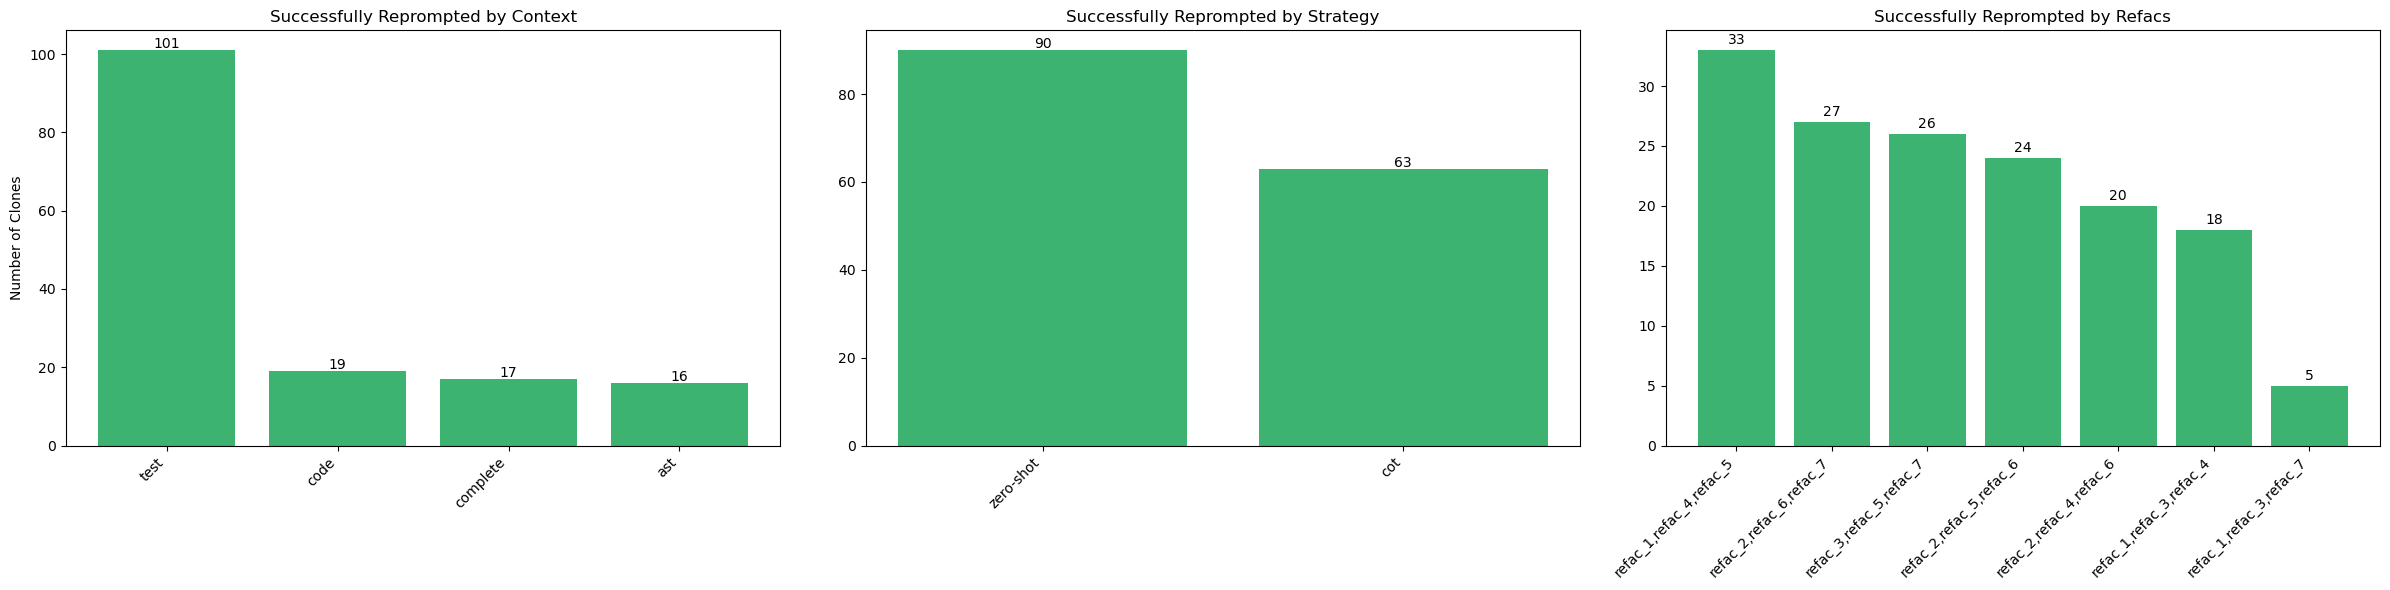

In [19]:
import json
import matplotlib.pyplot as plt 
with open(FILTERED_PATH_CODEBLEU, "r", encoding="utf-8") as f:
    before_data = json.load(f)

with open(REPROMPT_PATH, "r", encoding="utf-8") as f:
    after_data = json.load(f) 
def index_clones(dataset):
    index = {}
    for entry in dataset:
        entry_id = entry.get("id")
        for clone in entry.get("clones", []):
            clone_id = clone.get("clone_id")
            index[(entry_id, clone_id)] = clone
    return index

before_index = index_clones(before_data)
after_index = index_clones(after_data) 
categories = ["Successfully Reprompted"]
 
grouped_context = {}
grouped_refacs = {}
grouped_strategy = {}

for key, before_clone in before_index.items():
    after_clone = after_index.get(key)
    if not after_clone:
        continue  # skip clones not reprompted

    before_results = before_clone.get("test_results", {})
    after_results  = after_clone.get("test_results", {})

    # Count number of passing tests
    before_pass = sum(1 for r in before_results.values() if isinstance(r, str) and r.upper() == "PASS")
    after_pass  = sum(1 for r in after_results.values()  if isinstance(r, str) and r.upper() == "PASS")

    improved = after_pass > before_pass
    if not improved:
        continue  # only count successfully reprompted clones

    context = after_clone.get("context", "unknown")
    strategy = after_clone.get("strategy", "unknown")
    refacs_list = after_clone.get("refacs", ["unknown"])
    refacs_key = ", ".join(refacs_list)

     
    grouped_context[context] = grouped_context.get(context, 0) + 1 
    grouped_strategy[strategy] = grouped_strategy.get(strategy, 0) + 1 
    grouped_refacs[refacs_key] = grouped_refacs.get(refacs_key, 0) + 1
 
def plot_grouped(ax, grouped_dict, title): 
    sorted_items = sorted(grouped_dict.items(), key=lambda x: x[1], reverse=True)
    filters, values = zip(*sorted_items) if sorted_items else ([], [])

    x = range(len(filters))
    ax.bar(x, values, color="mediumseagreen")
    ax.set_xticks(x)
    ax.set_xticklabels(filters, rotation=45, ha="right", fontsize=10)
    ax.set_title(title)
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha="center", fontsize=10)
 
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

plot_grouped(axes[0], grouped_context, "Successfully Reprompted by Context")
plot_grouped(axes[1], grouped_strategy, "Successfully Reprompted by Strategy")
plot_grouped(axes[2], grouped_refacs, "Successfully Reprompted by Refacs")

axes[0].set_ylabel("Number of Clones")
plt.tight_layout()
plt.show()


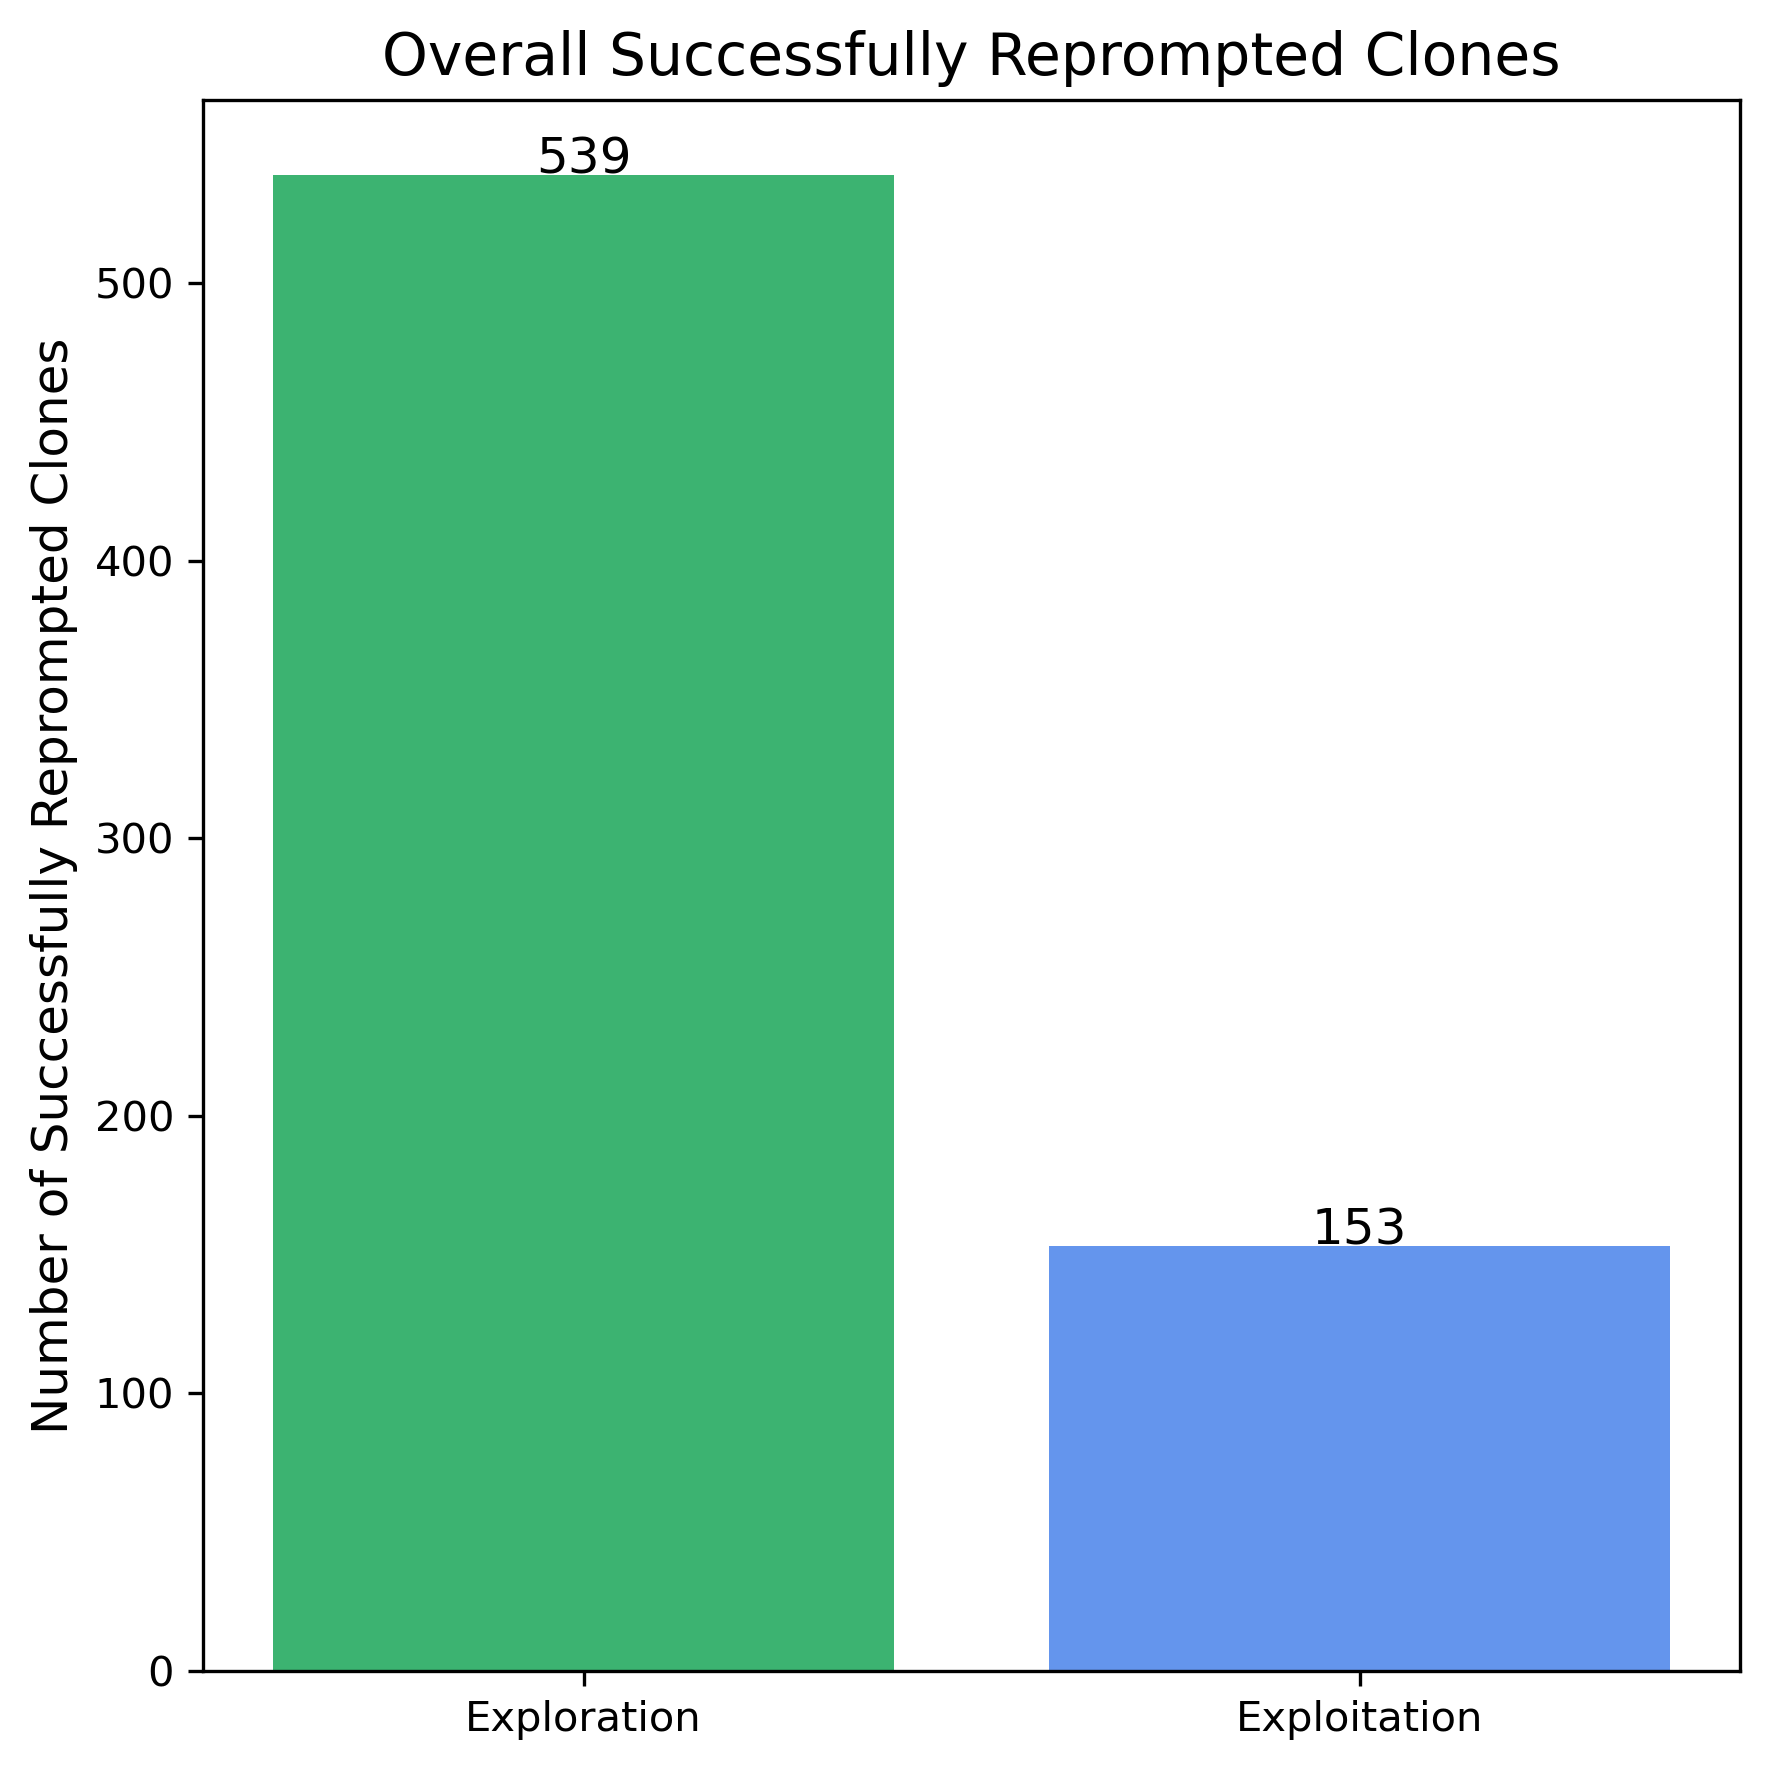

In [20]:
import json
import matplotlib.pyplot as plt
import os 
datasets_paths = {
    "Exploration": RQ1_REPROMPT_PATH,
    "Exploitation": REPROMPT_PATH
}

#  Index clone 
def index_clones(dataset):
    index = {}
    for entry in dataset:
        entry_id = entry.get("id")
        for clone in entry.get("clones", []):
            clone_id = clone.get("clone_id")
            index[(entry_id, clone_id)] = clone
    return index

#  Count total successfully reprompted clones 
def total_successful(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    index = index_clones(data)
    total = 0
    for clone in index.values():
        results = clone.get("test_results", {})
        passes = sum(1 for r in results.values() if isinstance(r, str) and r.upper() == "PASS")
        if passes > 0:  # count clones with at least one passing test
            total += 1
    return total
 
datasets = list(datasets_paths.keys())
counts = [total_successful(datasets_paths[name]) for name in datasets] 
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
bars = ax.bar(datasets, counts, color=["mediumseagreen", "cornflowerblue"])
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha="center", fontsize=12)

ax.set_ylabel("Number of Successfully Reprompted Clones", fontsize=12)
ax.set_title("Overall Successfully Reprompted Clones", fontsize=14)

plt.tight_layout()
pdf_path = os.path.join(PLOT_RESULTS, "RQ2Reprompted.pdf")
plt.savefig(pdf_path, format="pdf", bbox_inches="tight", dpi=300)
plt.show() 

### Clustering

In [21]:
from src.steps.clustering import process_clusters_for_entry
import json, warnings
warnings.filterwarnings("ignore")
with open(FILTERED_PATH_TESTS, "r", encoding="utf-8") as f:
    data = json.load(f)
process_clusters_for_entry(entry=data[3],clusters_dir=CLUSTER_DIR,representatives_json=FINAL_DATASET)

Saved cluster 1 for BigCodeBench/551 -> ../results/RQ2/clustering\clusters\BigCodeBench_551\cluster_1.py
Saved cluster 0 for BigCodeBench/551 -> ../results/RQ2/clustering\clusters\BigCodeBench_551\cluster_0.py
Saved cluster 2 for BigCodeBench/551 -> ../results/RQ2/clustering\clusters\BigCodeBench_551\cluster_2.py
Saved representatives for BigCodeBench/551 -> ../results/RQ2/clustering\clusters\BigCodeBench_551\representatives\BigCodeBench_551_representatives.py


In [22]:
import pandas as pd 
df = pd.read_csv(f"{CLUSTER_DIR}/all_clusters.csv") 
df["clone_list"] = df["clone_ids"].apply(lambda x: x.split(";") if pd.notna(x) else [])
 
clones_per_cluster = df.groupby("cluster_id")["num_clones"].sum()
stats = {
    "total_entries": len(df),
    "total_clusters": df["cluster_id"].nunique(),
    "total_clones": df["num_clones"].sum(),
    "avg_clones_per_cluster": clones_per_cluster.mean(),
    "std_clones_per_cluster": clones_per_cluster.std(),  
    "min_clones_per_cluster": clones_per_cluster.min(),
    "max_clones_per_cluster": clones_per_cluster.max()
}

print("=== Cluster Statistics ===")
for k, v in stats.items():
    print(f"{k}: {v}")



=== Cluster Statistics ===
total_entries: 134
total_clusters: 11
total_clones: 804
avg_clones_per_cluster: 73.0909090909091
std_clones_per_cluster: 108.45501790646162
min_clones_per_cluster: 1
max_clones_per_cluster: 285


### Missing entries

In [23]:
import json 
with open(FILTERED_PATH_CODEBLEU, "r", encoding="utf-8") as f:
    data1 = json.load(f)

with open(FINAL_DATASET, "r", encoding="utf-8") as f:
    data2 = json.load(f) 
ids1 = {item["id"] for item in data1}
ids2 = {item["id"] for item in data2}

#  Find missing IDs 
missing_ids = ids1 - ids2

if missing_ids:
    print(f"{len(missing_ids)} entries missing in final dataset:\n")
    for item in data1:
        if item["id"] in missing_ids:
            clones = item.get("clones", [])
            total_tests = 0
            if clones:
                first_clone = clones[0]
                test_results = first_clone.get("test_results", {})
                total_tests = len(test_results)
            print(f"{item['id']} - total tests: {total_tests}")
else:
    print("All entries from the first dataset are present in the second.")

7 entries missing in final dataset:

BigCodeBench/36 - total tests: 6
BigCodeBench/396 - total tests: 5
BigCodeBench/412 - total tests: 6
BigCodeBench/566 - total tests: 6
BigCodeBench/659 - total tests: 1
BigCodeBench/1098 - total tests: 5
BigCodeBench/1120 - total tests: 12
